[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldomunaretto/immune_deep_learning/blob/main/notebooks/03_RNN/20_RNN_time_series_homework.ipynb)

**LIBRERIAS**

In [ ]:
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

**DATOS**

In [ ]:
# Descargar datos, en el directorio actual
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [ ]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv") # Ruta donde se encuentra el archivo a cargar
df = pd.read_csv(path, parse_dates=["service_date"])                          # Lee el arvhivo y toma parse_dates como columna de fechas
df.columns = ["date", "day_type", "bus", "rail", "total"]                     # Renombra las columnas del dataframe
df = df.sort_values("date").set_index("date")                                 # Ordena el dataframe en base a la columna date y la selecciona como indice
df = df.drop("total", axis=1)                                                 # Elimina la columna total
df = df.drop_duplicates()                                                     # Elimina meses duplicados

df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


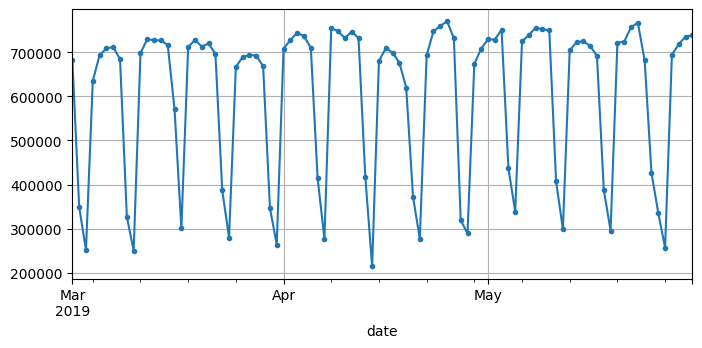

In [ ]:
# Grafica de algunos meses del año 2019
df["rail"]["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [ ]:
#Particion de set de datos Train,Validation y Test
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

print("Tamaño Train = " , rail_train.to_numpy().shape)
print("Tamaño Valid = " , rail_valid.to_numpy().shape)
print("Tamaño Test = "  , rail_test.to_numpy().shape)

Tamaño Train =  (1096,)
Tamaño Valid =  (151,)
Tamaño Test =  (914,)


In [ ]:
# Convirtiendo datos en series de tiempo
seq_length = 56                                                 # Series o pasos de tiempo como entrada para predecir el siguiente paso
tf.random.set_seed(42)                                          # Grantizar la reproducibilodad de los resultados
train_ds = tf.keras.utils.timeseries_dataset_from_array(        # Creacion de data set de series de tiempo
    rail_train.to_numpy(),                                      # Datos
    targets=rail_train[seq_length:],                            # Valores Objetivo - para que el modelo tomé las primeras 56 muestras como entrada y trata de predecir la siguiente
    sequence_length=seq_length,                                 # Longitud de de secuencia de entrada
    batch_size=32,                                              # Dataset dividido en lotes (32)
    shuffle=True,                                               # Mezcar los datos
    seed=42                                                     # Semilla para procurar la reproducibilidad
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32


)

**Simple RNN(Recurrent Neural Network)**

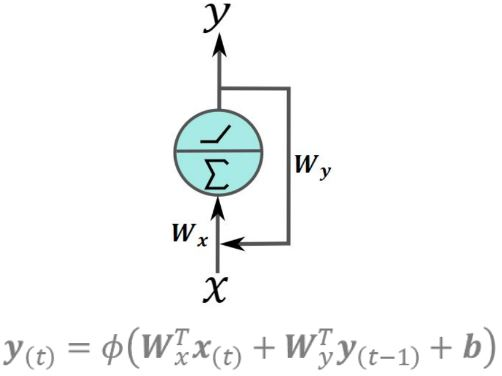

In [ ]:
model = tf.keras.Sequential([                                                   # Modelo secuencial
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])                         # Capa con una RNN (Recurrent Neural Network)
])

In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(                       # Callback EarlingStopping, restaurando los pesos del mejor modelo entrenado
        monitor="val_mae", patience=70, restore_best_weights=True)

    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)    # Optimizador Decenso de Gradiente Estocástico

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"]) # Compilacion del modelo : Funcion de perdida Hubber,optimizador SGD y error absoluto medio (mae) como métrica

    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,    # Entrenamiento del modelo (fit)
                        callbacks=[early_stopping_cb])

    valid_loss, valid_mae = model.evaluate(valid_set)                           # Perdia y mae de validacion

    return valid_mae * 1e6                                                      # Se multiplica valid_mae por 1 millon para presentar mejor los resultados

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)                 # Se invoca la funcion fit_and_evaluate para hacer Compilacion , Entrenamiento etc

Epoch 1/500
33/33 [==============================] - 2s 23ms/step - loss: 0.4360 - mae: 0.7687 - val_loss: 0.0645 - val_mae: 0.3190
Epoch 2/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0357 - mae: 0.2099 - val_loss: 0.0422 - val_mae: 0.2340
Epoch 3/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0223 - mae: 0.1557 - val_loss: 0.0147 - val_mae: 0.1472
Epoch 4/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0154 - mae: 0.1604 - val_loss: 0.0151 - val_mae: 0.1344
Epoch 5/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0150 - mae: 0.1521 - val_loss: 0.0145 - val_mae: 0.1393
Epoch 6/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0147 - mae: 0.1539 - val_loss: 0.0145 - val_mae: 0.1354
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0145 - mae: 0.1515 - val_loss: 0.0143 - val_mae: 0.1360
Epoch 8/500
33/33 [==============================] - 1s 15ms/step - loss: 0.

102813.16936016083

**DEEP RNN**

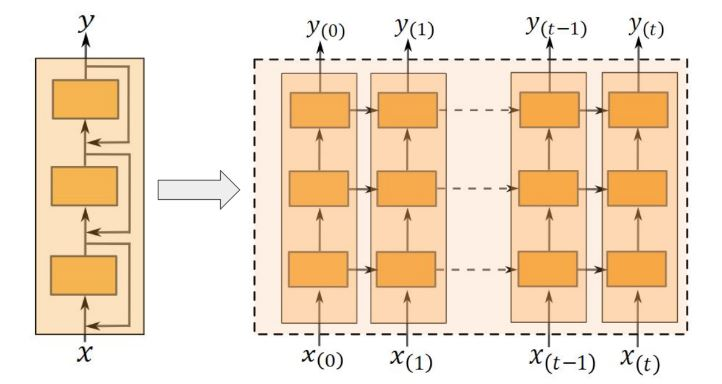

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([                                                # Modelo secuencial
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),  # Capa con 32 RNN, la cual tiene como salida cada paso de tiempo
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(1)                                                  # Capa con 1 RNN, la cual tiene como salida el ultimo paso de tiempo
])

In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.02)              # Se invoca la funcion fit_and_evaluate para hacer Compilacion , Entrenamiento etc

Epoch 1/500
33/33 [==============================] - 4s 53ms/step - loss: 0.0285 - mae: 0.1621 - val_loss: 0.0064 - val_mae: 0.0832
Epoch 2/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0059 - mae: 0.0796 - val_loss: 0.0030 - val_mae: 0.0605
Epoch 3/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0041 - mae: 0.0617 - val_loss: 0.0020 - val_mae: 0.0406
Epoch 4/500
33/33 [==============================] - 2s 72ms/step - loss: 0.0034 - mae: 0.0519 - val_loss: 0.0020 - val_mae: 0.0398
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0019 - val_mae: 0.0370
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0033 - mae: 0.0516 - val_loss: 0.0019 - val_mae: 0.0350
Epoch 7/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0026 - val_mae: 0.0488
Epoch 8/500
33/33 [==============================] - 1s 40ms/step - loss: 0.

29576.54744386673

**DEEP LSTM(The Long Short-Term Memory)**

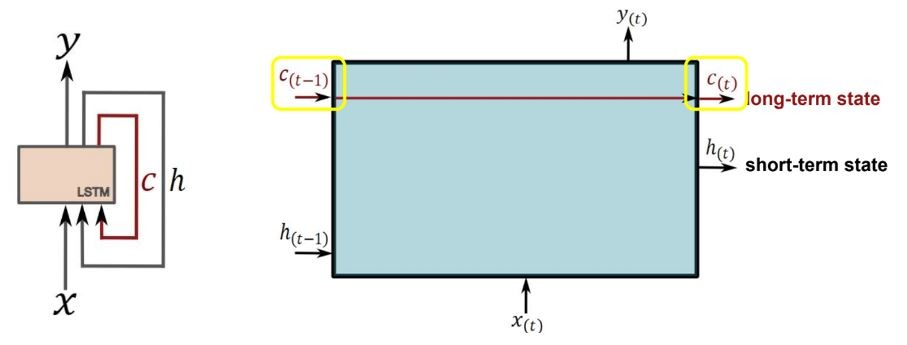

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),      # Modelo secuencial
    tf.keras.layers.LSTM(32, return_sequences=True),                             # Capa con 32 LSTM, la cual tiene como salida cada paso de tiempo
    tf.keras.layers.LSTM(1)                                                      # Capa con 1 LSTM, la cual tiene como salida el ultimo paso de tiempo
])


In [ ]:
fit_and_evaluate(lstm_model, train_ds, valid_ds, learning_rate=0.02)              # Se invoca la funcion fit_and_evaluate para hacer Compilacion , Entrenamiento etc

Epoch 1/500
33/33 [==============================] - 61s 132ms/step - loss: 0.0167 - mae: 0.1574 - val_loss: 0.0161 - val_mae: 0.1430
Epoch 2/500
33/33 [==============================] - 4s 115ms/step - loss: 0.0165 - mae: 0.1607 - val_loss: 0.0161 - val_mae: 0.1430
Epoch 3/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0165 - mae: 0.1602 - val_loss: 0.0162 - val_mae: 0.1416
Epoch 4/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0165 - mae: 0.1600 - val_loss: 0.0161 - val_mae: 0.1425
Epoch 5/500
33/33 [==============================] - 3s 102ms/step - loss: 0.0165 - mae: 0.1601 - val_loss: 0.0162 - val_mae: 0.1413
Epoch 6/500
33/33 [==============================] - 4s 113ms/step - loss: 0.0165 - mae: 0.1604 - val_loss: 0.0161 - val_mae: 0.1422
Epoch 7/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0165 - mae: 0.1606 - val_loss: 0.0162 - val_mae: 0.1415
Epoch 8/500
33/33 [==============================] - 3s 82ms/step - los

140365.6005859375

**DEEP GRU**

Comparativa entre los modelos usados:

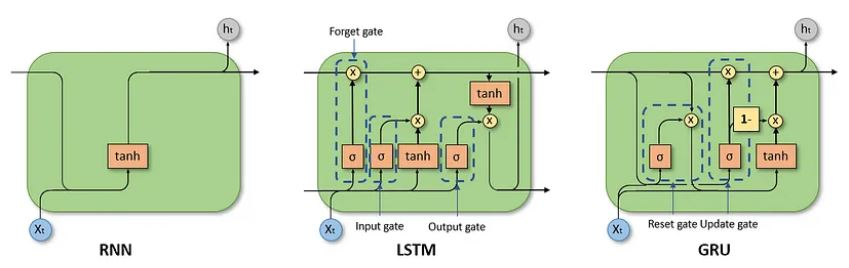

In [ ]:
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 1]),      # Modelo secuencial
    tf.keras.layers.GRU(32, return_sequences=True),                             # Capa con 32 GRU, la cual tiene como salida cada paso de tiempo
    tf.keras.layers.GRU(1)                                                      # Capa con 1  GRU, la cual tiene como salida el ultimo paso de tiempo
])

In [ ]:
fit_and_evaluate(gru_model, train_ds, valid_ds, learning_rate=0.02)              # Se invoca la funcion fit_and_evaluate para hacer Compilacion , Entrenamiento etc

Epoch 1/500
33/33 [==============================] - 11s 127ms/step - loss: 0.0683 - mae: 0.3147 - val_loss: 0.0678 - val_mae: 0.3224
Epoch 2/500
33/33 [==============================] - 4s 117ms/step - loss: 0.0312 - mae: 0.2029 - val_loss: 0.0181 - val_mae: 0.1297
Epoch 3/500
33/33 [==============================] - 5s 140ms/step - loss: 0.0171 - mae: 0.1583 - val_loss: 0.0176 - val_mae: 0.1328
Epoch 4/500
33/33 [==============================] - 3s 90ms/step - loss: 0.0170 - mae: 0.1598 - val_loss: 0.0178 - val_mae: 0.1310
Epoch 5/500
33/33 [==============================] - 3s 90ms/step - loss: 0.0170 - mae: 0.1612 - val_loss: 0.0162 - val_mae: 0.1466
Epoch 6/500
33/33 [==============================] - 5s 145ms/step - loss: 0.0166 - mae: 0.1618 - val_loss: 0.0162 - val_mae: 0.1454
Epoch 7/500
33/33 [==============================] - 4s 108ms/step - loss: 0.0166 - mae: 0.1614 - val_loss: 0.0165 - val_mae: 0.1419
Epoch 8/500
33/33 [==============================] - 3s 87ms/step - lo

129734.50124263763